In [5]:
import csv
import shapefile
import shapely.geometry as geom
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl

import math
import numpy as np
from numpy import linalg as la
import statistics as stat

import ternary
from ternary.helpers import simplex_iterator

In [6]:
DEM = "DEM"
REP = "REP"

CANDIDATES = {
    2000: {DEM: 'Al Gore', REP: 'George Bush'},
    2004: {DEM: 'John Kerry', REP: 'George Bush'},
    2008: {DEM: 'Barack Obama', REP: 'John Mccain'},
    2012: {DEM: 'Barack Obama', REP: 'Mitt Romney'},
    2016: {DEM: 'Clinton, Hillary', REP: 'Trump, Donald J'}
}

STATE_CODES = {
    "PA": 42
}

YEAR = 2016
STATE = "PA"

RC = CANDIDATES[YEAR][REP]
DC = CANDIDATES[YEAR][DEM]

In [7]:
sf = shapefile.Reader("PA/tl_2011_us_county/tl_2011_us_county")
COUNTY_SHAPES = {}
iter = sf.iterShapeRecords()
for i in iter:
    if i.record[0] == '42':
        s = geom.shape(i.shape)
        COUNTY_SHAPES[i.record[4].capitalize()]=s
#         print(i.record[4].capitalize(),s.area)
        
print(len(COUNTY_SHAPES.keys()))

67


In [8]:
def load_results(year):
    res = {}
    with open("PA/"+str(year) + "_county.csv",'r') as f:
        reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:
            county = row["County"]
            del row["County"]

            res[county] = row
    return res

COUNTY_RESULTS = load_results(YEAR)
print(COUNTY_RESULTS['Allegheny'])

{'Castle, Darrell L': 1793.0, 'Trump, Donald J': 257488.0, 'Clinton, Hillary': 363017.0, 'Johnson, Gary E': 15854.0, 'Stein, Jill': 5021.0}


In [9]:
def load_registrations(year):
    res = {}
    with open("PA/" + str(year) + "_registerd_voters_county.csv",'r') as f:
        reader = csv.DictReader(f, quoting=csv.QUOTE_NONNUMERIC)
        for row in reader:
            res[row["County"].capitalize()] = row
    return res

VOTERS = load_registrations(YEAR)
VOTERS['Allegheny']

{'ALL': 924573.0,
 'County': 'ALLEGHENY',
 'DEM': 539866.0,
 'ID#': 2291.0,
 'NOF': 72740.0,
 'OTH': 52444.0,
 'REP': 259523.0}

In [10]:
dem_votes = sum([k[DC] for k in COUNTY_RESULTS.values()])
rep_votes = sum([k[RC] for k in COUNTY_RESULTS.values()])
total = sum([sum(k.values()) for k in COUNTY_RESULTS.values()])
vap = sum([VOTERS[k]["ALL"] for k in VOTERS.keys()])
winner = DC
if rep_votes > dem_votes:
    winner = RC
print(winner+" won the election by " + str(round(abs(dem_votes-rep_votes)/total*100, 2)) + "%")
print("there was a total of " + str(int(total)) + " votes cast")
print("voter turnout for state was " + str(round(total/vap*100,2)) + "% (" + str(int(total)) + " of " +str(int(vap)) + ")")

Trump, Donald J won the election by 1.16%
there was a total of 6009166 votes cast
voter turnout for state was 68.89% (6009166 of 8722938)


In [11]:
def plot_pa_data(colors, cmap=None, norm=None):
    if cmap is not None:
        fig = plt.figure()#figsize=(8, 3))
        ax = fig.add_axes([0.05, 0.05, 0.85, 0.9], projection=ccrs.PlateCarree())
        ax2 = fig.add_axes([0.925, 0.15, 0.05, 0.7])
    else:
        ax = plt.axes(projection=ccrs.PlateCarree())
        
    for county,v in COUNTY_SHAPES.items():
        color = colors[county]
        cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree())
        ax.add_feature(cf, facecolor=color)

    ax.set_extent([-80.5198510000000027,-74.7215190000000007,39.7211469999999949,42.5160720000000012])
    ax.set_aspect(1)
    if cmap is not None:
        cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=cmap, norm=norm, extend='max')
    plt.show()

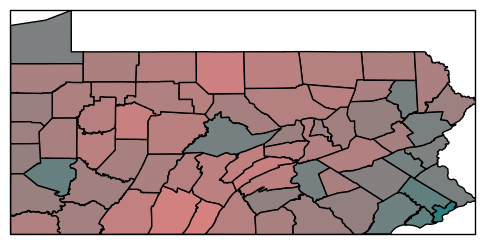

In [12]:
values = {}
for county,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    values[county] = (meta[RC]/total,0.5,0.5)
plot_pa_data(values)

28281236.1447 27698.6789508


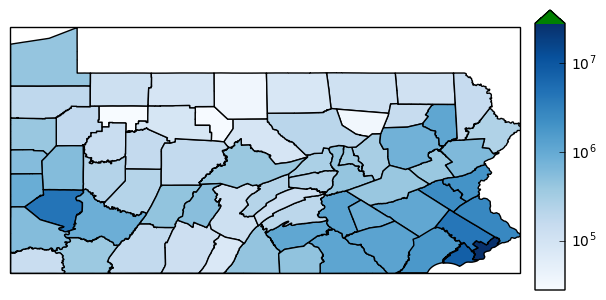

In [13]:

# ax = plt.axes(projection=ccrs.PlateCarree())
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

norm = colors.LogNorm()

to_plot = []
for county,v in COUNTY_SHAPES.items():
    vap = int(dict(VOTERS[county])["ALL"])
    value = vap/v.area
    to_plot.append((county, v, value))

norm.autoscale_None([k[2] for k in to_plot])
print(norm.vmax, norm.vmin)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)

values = {}
for (county, shape, value) in to_plot:
    color = sm.to_rgba(value)
    values[county] = color
#     print("sm:", k, value, color)

plot_pa_data(values, cmap=colormap, norm=norm)

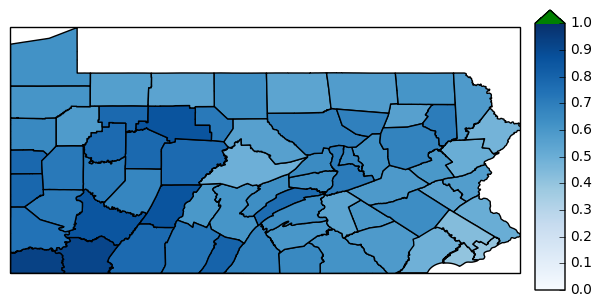

In [26]:
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

values = {}
for k,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[k]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    vap = VOTERS[k]["ALL"]
#     color = total/vap
#     value = int(meta["CLINTON, HILLARY"])/int(VOTERS[k]["DEM"])
#     value = int(meta["TRUMP, DONALD J"])/int(VOTERS[k]["REP"])
#     value = int(meta["TRUMP, DONALD J"])/sum([int(VOTERS[k]["REP"]), int(VOTERS[k]["OTH"]), int(VOTERS[k]["NOF"])])
    value = trump/((vap-VOTERS[k][DEM])-(total-trump-clinton))
#     value = clinton/((vap-VOTERS[k]["REP"])-(total-trump-clinton))
    color = colormap(value)
    values[k] = color
    if value > 1:
        print(k, value)

plot_pa_data(values, cmap=colormap)

0.781357745809 0.611632768174
['Adams: 0.7119042978997706', 'Allegheny: 0.6956432861439822', 'Armstrong: 0.7430438052265463', 'Beaver: 0.6959293469168523', 'Bedford: 0.6859257109692397', 'Berks: 0.6772109995688859', 'Blair: 0.6684868497128393', 'Bradford: 0.6827972696608324', 'Bucks: 0.7476509484153266', 'Butler: 0.7480169283781596', 'Cambria: 0.726719668164535', 'Cameron: 0.6761521806371791', 'Carbon: 0.6802539020866394', 'Centre: 0.6173778386748932', 'Chester: 0.7525804621546329', 'Clarion: 0.7275631716526285', 'Clearfield: 0.6438770525682936', 'Clinton: 0.6903139013452915', 'Columbia: 0.6643401170621801', 'Crawford: 0.7023735926113266', 'Cumberland: 0.7282019040776001', 'Dauphin: 0.6876888396117852', 'Delaware: 0.6909087826299688', 'Elk: 0.712641406906091', 'Erie: 0.6502781370600544', 'Fayette: 0.6411977961695328', 'Forest: 0.7199039327529271', 'Franklin: 0.7495700219288817', 'Fulton: 0.7339719168390116', 'Greene: 0.6620185922974767', 'Huntingdon: 0.6616970551694034', 'Indiana: 0.72

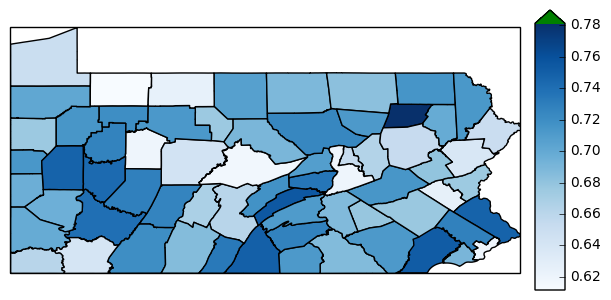

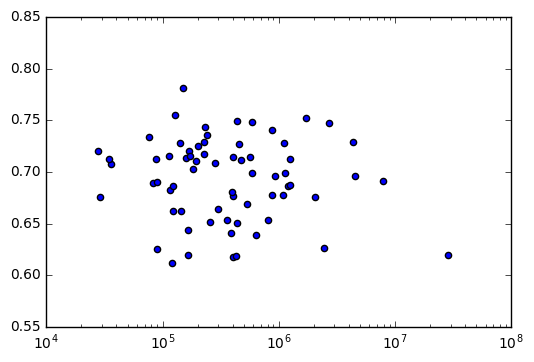

In [64]:
# colormap = cm.get_cmap("bwr_r")
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

norm = colors.Normalize()

to_plot = []
for county,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    vap = VOTERS[county]["ALL"]
    
    republicans = VOTERS[county]["REP"]/vap*100
    democrats = VOTERS[county]["DEM"]/vap*100
    value = ((clinton-trump)/total*100)-(democrats-republicans)
    value =total/vap
    d = vap/v.area
    to_plot.append((county, v, value, d))

norm.autoscale_None([k[2] for k in to_plot])
print(norm.vmax, norm.vmin)
m = max(abs(norm.vmax), abs(norm.vmin))
# norm = colors.Normalize(vmin=-m, vmax=m)

sm = cm.ScalarMappable(norm=norm, cmap=colormap)

values = {}
for (county, shape, value, g) in to_plot:
    color = sm.to_rgba(value)
    values[county] = color
#     print("sm:", county, value, color)

print([x[0] + ": " + str(x[2]) for x in sorted(to_plot, key=lambda x: x[0])])
    
plot_pa_data(values, cmap=colormap, norm=norm)

plt.figure()
plt.scatter([x[3] for x in to_plot], [x[2] for x in to_plot])
ax = plt.gca()
ax.set_xscale('log')
plt.show()

[-25.351058544350344, -35.28682293959034, -14.119031035119361, -20.328587201796054, -34.72738957723545, -15.859449866688422, 14.461174468789737, -10.076509969761412, -35.19556633425335, -19.600853404989355, -16.556037697906625, -25.821993200306, -22.20223180779654, -12.646078696844043, -2.3513148672087176, -15.928849899950748, -13.462331497705785, -3.947183982604585, -36.67717237799402, -20.23859938797255, -13.0328907316615, -29.25461422753314, -1.2345200700326968, -36.29158399966531, -55.616510549202616, -0.3311431392942339, -61.244734646613594, -24.232672519846517, -29.386523739017612, -22.74822568633429, -35.12010746905234, -14.772136673844969, -38.34465780930415, -51.582096881624196, 0.9356092683468944, -9.985612893895485, 11.623915697094676, -0.45707988527535726, -31.760982395881598, -16.503523713288835, -27.28960402086992, -12.498192988996458, -14.198407022655978, -14.65942879640189, 17.728621176865914, -35.77597748395567, -27.074115340925296, -21.8906931838133, -48.0153004984995

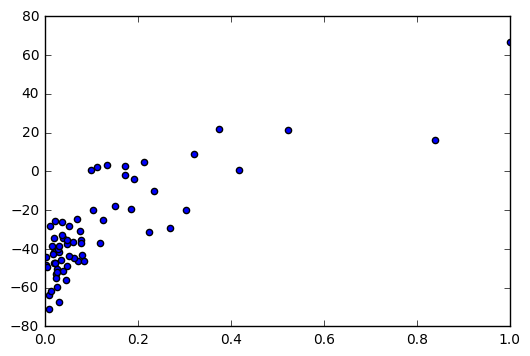

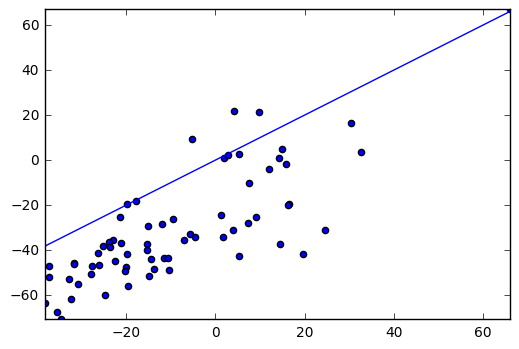

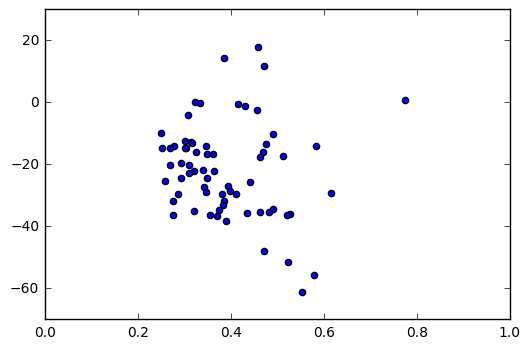

In [67]:
x=[]
clintons = []
trumps=[]
counties = COUNTY_RESULTS.keys()
vap=[int(dict(VOTERS[c])["ALL"]) for c in counties]
vap = [i/max(vap) for i in vap]

for county in COUNTY_RESULTS.keys():
    meta = COUNTY_RESULTS[county]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    x.append((clinton-trump)/total*100)
    trumps.append(trump/total*100)
    clintons.append(clinton/total*100)
#     x.append((total-clinton-trump)/total*100)
plt.figure()
plt.scatter(vap,x)
plt.xlim([0,1])

republicans = [int(dict(VOTERS[c])["REP"])/int(dict(VOTERS[c])["ALL"]) for c in counties]
democrats = [int(dict(VOTERS[c])["DEM"])/int(dict(VOTERS[c])["ALL"]) for c in counties]
x_v = [(i-j)*100 for i,j in zip(democrats,republicans)]
plt.figure()
plt.scatter(x_v, x)
print([i-j for i,j in zip(x, x_v)])
plt.plot([-100,100],[-100,100])
plt.xlim([min(x_v),max(x_v)])
plt.ylim([min(x),max(x)])
# plt.xlim([0,1])
plt.figure()
plt.scatter(democrats,[i-j for i,j in zip(x,x_v)])
plt.xlim([0,1])
# plt.figure()
# plt.scatter(vap,democrats)
# plt.xlim([0,1])
plt.show()


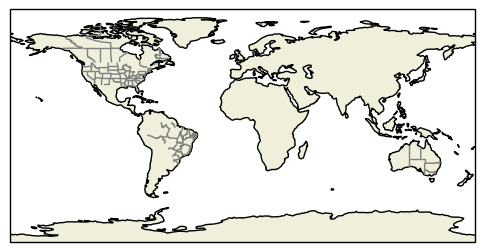

In [16]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from matplotlib.offsetbox import AnchoredText


ax = plt.axes(projection=ccrs.PlateCarree())
#ax.set_extent([80, 170, -45, 30])

# Put a background image on for nice sea rendering.
#ax.stock_img()

# Create a feature for States/Admin 1 regions at 1:50m from Natural Earth
states_provinces = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_1_states_provinces_lines',
    scale='50m',
    facecolor='none')

SOURCE = 'Natural Earth'
LICENSE = 'public domain'

ax.add_feature(cfeature.LAND)
ax.add_feature(cfeature.COASTLINE)
ax.add_feature(states_provinces, edgecolor='gray')

# Add a text annotation for the license information to the
# the bottom right corner.
text = AnchoredText(r'$\mathcircled{{c}}$ {}; license: {}'
                    ''.format(SOURCE, LICENSE),
                    loc=4, prop={'size': 12}, frameon=True)
# ax.add_artist(text)

plt.show()

In [168]:
def plot_cmap(cmap, vmax=100, filter=lambda x,y: x+y <= 100, foo=1):
    n=vmax//foo + 1
    xs = np.linspace(0, vmax, n)
    xv, yv = np.meshgrid(xs, xs)
    colors = np.zeros([n,n]).tolist()
    grid = np.dstack((xv, yv))
    ps = []
    for i in range(n):
        for j in range(n):
            x,y = (xv[j,i], yv[j,i])
            if filter(x,y):
                res = cmap((x,y))
                if res is None or np.any(np.isnan(res)):
                    res = (0,0,0)
                if np.any(np.isnan(res)):
                    print((x,y), res)
                colors[j][i] = res
            else:
                colors[j][i] = (0,0,0)
#     print(colors)
    plt.imshow(colors, origin='lower')
    plt.show()

In [24]:
t = np.dtype([('x', float), ('y', float)])
a = np.array([(1,2), (3,4)], dtype=t)
a[1]['x']

3.0

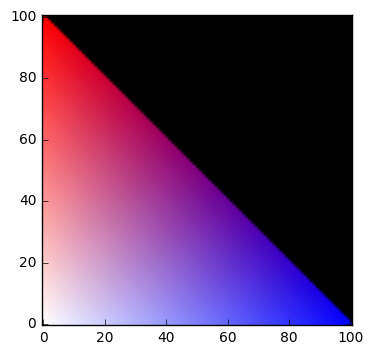

In [81]:
# generate corners of regular n-poly centered at 0,0
def poly_corners(n):
    step = 2*math.pi/n
    return np.array([[math.cos(step*i), math.sin(step*i)] for i in range(n)])

def regular_simplex(n):
    # TODO: implement general approach to compute regular n-simplex
    # https://en.wikipedia.org/wiki/Simplex#Cartesian_coordinates_for_regular_n-dimensional_simplex_in_Rn
    if n==3: return poly_corners(3)
    if n==4: return np.array([
                [1,0,0],
                [-1/3,math.sqrt(8)/3,0],
                [-1/3,-math.sqrt(2)/3,math.sqrt(2/3)],
                [-1/3,-math.sqrt(2)/3,-math.sqrt(2/3)]
                             ])
    if n==5: return np.array([
                [1,0,0,0],
                [-1/4,math.sqrt(15)/4,0,0],
                [-1/4,-math.sqrt(15)/12,math.sqrt(10/12),0],
                [-1/4,-math.sqrt(15)/12,-math.sqrt(30)/12,-math.sqrt(10)/4],
                [-1/4,-math.sqrt(15)/12,-math.sqrt(30)/12,math.sqrt(10)/4]
                             ])

def homogenize(points, out_dim):
    n = len(points)
    res = np.array(points)
    in_dim = len(points[0])
    if in_dim < out_dim:
        res = np.concatenate((res, np.zeros((n,out_dim-in_dim))), axis=1)
    return np.concatenate((res,np.ones((n,1))), axis=1)

def project(a,b):
    a_ = np.array(a)
    b_ = np.array(b)
    return np.dot(a_.T,b_)/np.dot(a_.T,a_)*a_

def gen_cmap(points, colors, lower=0):
    n = len(points)
    a = homogenize(points,n-1)
    b = regular_simplex(n)
#     b = poly_corners(n)
#     print(n,a,b)
#     x = la.solve(a,b)
    x = la.lstsq(a,b)[0]
#     print(x, np.dot(a,x), b)
#     max_dist = la.norm(b[0]-b[1])
    max_dist = la.norm(project(-b[0], b[1]-b[0]))
#     print(max_dist)
    def cmap(ps):
        if len(np.array(ps).shape) == 1:
            ps = [ps]
        a = homogenize(ps,n-1)
#         print(a, x)
        nps = np.dot(a,x)
#         print(nps)
#         distances = [[max(max_dist-la.norm(p-c),0) for c in b] for p in nps]
        distances = [[max(max_dist-la.norm(project(-c, p-c)), 0) for c in b] for p in nps]
        norm_dist = [np.array(k)/sum(k) for k in distances]
        out = np.dot(norm_dist, colors).clip(min=0.0, max=1.0)
#         print(ps, nps.tolist(), distances, out)
        return out.tolist()[0]
    return cmap

# print(project([-1,-1,-1], [1,2,3]))
cmap = gen_cmap([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[100,0], [100,100], [0,100], [0,0]], [(0,0,1), (1,1,1), (1,0,0), (0,0,0)])

# basis
#cmap = gen_cmap([[60,35], [100,0], [0,100], [35,60]], [(1,1,1), (0,0,1), (1,0,0), (1,1,1)])
# better resolution of red v blue
# cmap = gen_cmap([[60,35], [100,0], [0,100], [35,60]], [(0.75,0.75,1), (0,0,1), (1,0,0), (1,0.75,0.75)])

## tests
# cmap = gen_cmap([[50,45], [100,0], [55,55], [0,100], [45,50]], [(1,1,1), (0,0,1), (1,1,1), (1,0,0), (1,1,1)])
# cmap = gen_cmap([[50,45], [100,0], [0,100], [45,50]], [(0,0,1,0), (0,0,1,1), (1,0,0,1), (1,0,0,0)])
# cmap = gen_cmap([[100,0], [100,100], [0,100], [0,0]], [[0.9803921568627451, 0.22745098039215686, 0.0],
#  [0.0, 0.09803921568627451, 0.8823529411764706],
#  [0.44313725490196076, 0.0, 0.9803921568627451],
#  [0.9882352941176471, 0.7254901960784313, 0.0]])

plot_cmap(cmap)
# plot_cmap(cmap, filter=lambda x,y: 95 <= x+y <= 100)

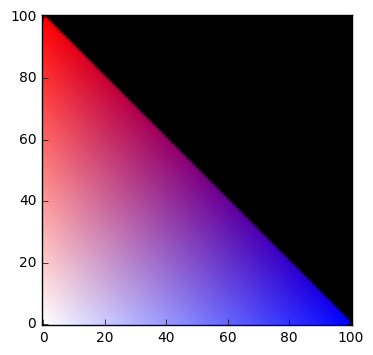

In [286]:
# 2D colormap, as ternary plot
# Barycentric coordinate approach (https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Interpolation_on_a_triangular_unstructured_grid)
# aka treat it as a ternary plot https://en.wikipedia.org/wiki/Ternary_plot

def homogenize(points):
    n = len(points)
    res = np.array(points)
    return np.concatenate((res,np.ones((n,1))), axis=1)

def gen_cmap(coords, colors):
    a = homogenize(coords).T
    def cmap(point):
        b = homogenize([point]).T
#         bpoints = la.solve(a,b)
        bpoints = la.lstsq(a,b)[0]
#         print(bpoints)
        if any(bpoints < -1e-08):
            return None
        return np.dot(bpoints.T,colors)[0]
    return cmap

cmap = gen_cmap([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[0,0], [100,10]], [(1,0,1), (1,0,0)])
# cmap = gen_cmap([[10,0], [100,0], [100,100], [10,100]], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)])


plot_cmap(cmap, filter= lambda x,y: True, foo=1)

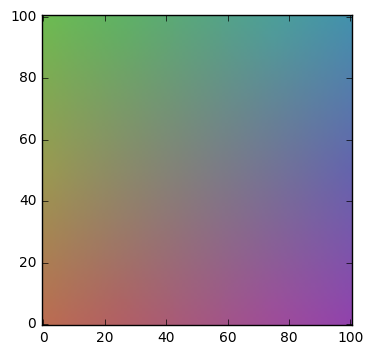

In [104]:
import itertools as itools

cmaps = []
def gen_cmap4(coords, values):
    for indices in itools.combinations(range(len(coords)), 3):
        cmaps.append(gen_cmap([coords[i] for i in indices], [values[i] for i in indices]))
    def cmap(point):
        outs = []
        for cmap in cmaps:
            res = cmap(point)
            if res is not None:
                outs.append(res)
#         print(outs)
        return np.mean(outs,axis=0)
    return cmap

def gen_cmap5(coords, values):
    max_dist = math.sqrt(2*100**2)
    def cmap(ps):
        if len(np.array(ps).shape) == 1:
            ps = [ps]
        distances = [[max(max_dist-la.norm(np.array(p)-np.array(c)), 0) for c in coords] for p in ps]
        norm_dist = [np.array(k)/sum(k) for k in distances]
        out = np.dot(norm_dist, values).clip(min=0.0, max=1.0)
#         print(ps, nps.tolist(), distances, out)
        return out.tolist()[0]
    return cmap

# cmap = gen_cmap4([[10,10], [90,10], [90,90], [10,90]], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)])
# cmap = gen_cmap4([[47.5, 47.5], [95,0], [100,0], [0,100], [0,95]], [(1,1,1), (0,0.75,1), (0,0,1), (1,0,0), (1,0.75,0)])
# cmap = gen_cmap4([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
# cmap = gen_cmap4([[50*(x+1) for x in p] for p in poly_corners(5)], [(0,0,0), (0,0,1), (1,0,0), (0,1,0), (1,1,1)])
cmap = gen_cmap5([[50*(x+1) for x in p] for p in poly_corners(6)], [(0,0,1), (0,1,1), (0,1,0), (1,1,0), (1,0,0), (1,0,1)])

# print(cmap((90,90)))
# print(cmap((80,80)))
# print(cmap((50,50)))

# print([x for x in itools.combinations(range(4),3)])
# plot_cmap(cmap, filter= lambda x,y:x+y<=100, foo=1)
plot_cmap(cmap, filter= lambda x,y: True, foo=1)
# for cmap in cmaps:
#     plot_cmap(cmap, filter= lambda x,y:True, foo=4)

# cmap = gen_cmap5([[10,10], [90,10], [90,90], [10,90]], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)])
# plot_cmap(cmap, filter= lambda x,y:True, foo=1)


barycentric coordinates: 3 
 [[ 0.30257563]
 [-0.30262718]
 [ 1.00005154]]
barycentric coordinates: 3 
 [[-0.31549021]
 [ 0.69742437]
 [ 0.61806584]]
barycentric coordinates: 3 
 [[-1.31554175]
 [ 1.31549021]
 [ 1.00005154]]
barycentric coordinates: 0 
 [[ 0.11554175]
 [ 0.69742437]
 [ 0.18703388]]
barycentric coordinates: 3 
 [[ -5.15427642e-05]
 [  8.13017662e-01]
 [  1.87033881e-01]]
barycentric coordinates: 3 
 [[ 0.81296612]
 [ 1.31549021]
 [-1.12845633]]
barycentric coordinates: 0 
 [[ 0.18695048]
 [ 0.51047388]
 [ 0.30257563]]
barycentric coordinates: 3 
 [[ -5.15427642e-05]
 [  8.13049517e-01]
 [  1.87002026e-01]]
barycentric coordinates: 3 
 [[ 0.50244069]
 [ 0.81304952]
 [-0.31549021]]
barycentric coordinates: 0 
 [[  8.12966119e-01]
 [  8.33979444e-05]
 [  1.86950483e-01]]
outs: 3 [array([ 0.69742437,  0.18703388,  0.        ]), array([ 0.51047388,  0.30257563,  0.18695048]), array([ 0.9999166 ,  0.18703388,  0.18695048])]
[ 0.73593828  0.2255478   0.12463366]
barycentric co

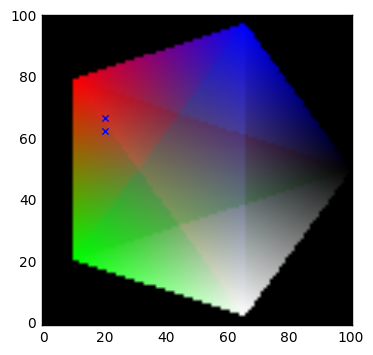

In [257]:
import itertools as itools

__SLACK__ = 1e-08

# 2D colormap, as ternary plot
# Barycentric coordinate approach (https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Interpolation_on_a_triangular_unstructured_grid)
# aka treat it as a ternary plot https://en.wikipedia.org/wiki/Ternary_plot

class ColorMap:
    INSIDE = 0
    VERTEX = 1
    EDGE = 2
    OUTSIDE = 3
    
    def __init__(self, coords, colors, verbose=False):
        self.coords = coords
        self.colors = colors
        self.cmaps = []
        self.verbose = verbose
        self._gen_cmaps()
        
        # If out of range, default to this color.
        self._oob_color = (0.0, 0.0, 0.0)
    
    def _print(self, *args):
        if self.verbose:
            print(*args)
    
    def _homogenize(self, coords):
        # create the corresponding homegenous coordinates 
        # for the input cartesian coordinates
        n = len(coords)
        res = np.array(coords)
        return np.concatenate((res,np.ones((n,1))), axis=1)

    def _gen_ternary_cmap(self, coords, colors):
        a = self._homogenize(coords).T
        def cmap(point):
            b = self._homogenize([point]).T
            bary_coords = la.solve(a,b)
            # Shouldn't be needed if always given exactly 3 coords
            # bary_coords = la.lstsq(a,b)[0]
            location = None
            color = None
            # if any coordinate is negative, point is outside triangle.
            if any(bary_coords < -__SLACK__):
                location = self.OUTSIDE
                color = self._oob_color
            # if any coordinate is 1 at this point, means exactly one
            # coord is 1 and must be on vertex
            elif (any(bary_coords > 1-__SLACK__)):
                location = self.VERTEX
            # if any coordinate is near 0 at this point, means on edge.
            elif any(bary_coords < __SLACK__):
                location = self.EDGE
            # otherwise, must be inside
            else:
                location = self.INSIDE
            if color is None:
                color = np.dot(bary_coords.T,colors)[0]
            self._print("barycentric coordinates:", location, "\n", bary_coords)
            return [color, location]
        return cmap

    def _gen_cmaps(self):
        # generate a ternary cmap for each triple of coords
        for indices in itools.combinations(range(len(self.coords)), 3):
            local_coords = [self.coords[i] for i in indices]
            local_colors = [self.colors[i] for i in indices]
            self.cmaps.append(self._gen_ternary_cmap(local_coords, local_colors))

    def __call__(self, point):
        outs = []
        weights = []
        for cmap in self.cmaps:
            color, location = cmap(point)
            if color is None or location is None:
                print("impossible!", point, color, location)
            if location <= self.VERTEX:
                outs.append(color)
                # INSIDE is obviously weight = 1
                # VERTEX means that all triangles will either have 
                # this as a vertex or OUTSIDE, so weight doesn't matter.
                weights.append(1)
            elif location == self.EDGE:
                outs.append(color)
                # for each point on an edge of any triangle, 
                # we expect n-2 other triangles to share that edge, and
                # produce the same value. To avoid double counting, we
                # give them all an appropriate weight.
                weights.append(1/(len(self.coords)-2))
        self._print("outs:", len(outs), outs)
        if len(outs) == 0:
            color = self._oob_color
        else:
            color = np.average(outs,axis=0, weights=weights)
        if color is None or np.any(np.isnan(color)):
            print("oob!", point, outs)
            color = self._oob_color
        return color
        
    def set_oob(self, color):
        self._oob_color = color
    
    def gen_tri_labels(self):
        for indices in itools.combinations(range(len(self.coords)), 3):
            local_coords = [self.coords[i] for i in indices]

# cmap = gen_cmap4([[10,10], [90,10], [90,90], [10,90]], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)])
# cmap = ColorMap([[10,10], [90,10], [90,90], [10,90]], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)], True)
# cmap.set_oob((1,1,1))
# cmap = gen_cmap4([[47.5, 47.5], [95,0], [100,0], [0,100], [0,95]], [(1,1,1), (0,0.75,1), (0,0,1), (1,0,0), (1,0.75,0)])
# cmap = gen_cmap4([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
cmap = ColorMap([[50*(x+1) for x in p] for p in poly_corners(5)], [(0,0,0), (0,0,1), (1,0,0), (0,1,0), (1,1,1)], True)
# cmap = ColorMap([[50*(x+1) for x in p] for p in poly_corners(6)], [(0,0,1), (0,1,1), (0,1,0), (1,1,0), (1,0,0), (1,0,1)])

# print(cmap((0,0)))
# print(cmap((90,90)))
# print(cmap((20,20)))
print(cmap((20,65)))
print(cmap((20,67)))

cmap.verbose = False

# print([x for x in itools.combinations(range(4),3)])
# plot_cmap(cmap, filter= lambda x,y:x+y<=100, foo=1)
plt.scatter([20, 20], [63, 67], marker='x')
plot_cmap(cmap, filter= lambda x,y: True, foo=1)
# for cmap in cmaps:
#     plot_cmap(cmap, filter= lambda x,y:True, foo=4)

In [274]:
import itertools as itools

__SLACK__ = 1e-08

# 2D colormap, as ternary plot
# Barycentric coordinate approach (https://en.wikipedia.org/wiki/Barycentric_coordinate_system#Interpolation_on_a_triangular_unstructured_grid)
# aka treat it as a ternary plot https://en.wikipedia.org/wiki/Ternary_plot

class ColorMap:
    INSIDE = 0
    VERTEX = 1
    EDGE = 2
    OUTSIDE = 3
    
    def __init__(self, coords, colors, verbose=False):
        self.coords = coords
        self.colors = colors
        self.cmaps = []
        self.verbose = verbose
        self._gen_cmaps()
        
        # If out of range, default to this color.
        self._oob_color = (0.0, 0.0, 0.0)
    
    def _print(self, *args):
        if self.verbose:
            print(*args)
    
    def _homogenize(self, coords):
        # create the corresponding homegenous coordinates 
        # for the input cartesian coordinates
        n = len(coords)
        res = np.array(coords)
        return np.concatenate((res,np.ones((n,1))), axis=1)

    def _gen_ternary_cmap(self, coords, colors):
        a = self._homogenize(coords).T
        def cmap(point):
            b = self._homogenize([point]).T
            bary_coords = la.solve(a,b)
            # Shouldn't be needed if always given exactly 3 coords
            # bary_coords = la.lstsq(a,b)[0]
            location = None
            color = None
            # if any coordinate is negative, point is outside triangle.
            if any(bary_coords < -__SLACK__):
                location = self.OUTSIDE
                color = self._oob_color
            # if any coordinate is 1 at this point, means exactly one
            # coord is 1 and must be on vertex
            elif (any(bary_coords > 1-__SLACK__)):
                location = self.VERTEX
            # if any coordinate is near 0 at this point, means on edge.
            elif any(bary_coords < __SLACK__):
                location = self.EDGE
            # otherwise, must be inside
            else:
                location = self.INSIDE
            if color is None:
                color = np.dot(bary_coords.T,colors)[0]
            np.clip(bary_coords, -1, 2, out=bary_coords)
            self._print("barycentric coordinates:", location, "\n", bary_coords.T)
            return [color, location, bary_coords.T[0,0:].tolist(), colors]
        return cmap

    def _gen_cmaps(self):
        # generate a ternary cmap for each triple of coords
        for indices in itools.combinations(range(len(self.coords)), 3):
            local_coords = [self.coords[i] for i in indices]
            local_colors = [self.colors[i] for i in indices]
            self.cmaps.append(self._gen_ternary_cmap(local_coords, local_colors))

    def __call__(self, point):
        outs = []
        weights = []
        for cmap in self.cmaps:
            color, location, b_coords, colors = cmap(point)
            if color is None or location is None:
                print("impossible!", point, color, location)
            outs.extend(colors)
            weights.extend(b_coords)
#             if location <= self.VERTEX:
#                 outs.append(color)
#                 # INSIDE is obviously weight = 1
#                 # VERTEX means that all triangles will either have 
#                 # this as a vertex or OUTSIDE, so weight doesn't matter.
#                 weights.append(1)
#             elif location == self.EDGE:
#                 outs.append(color)
#                 # for each point on an edge of any triangle, 
#                 # we expect n-2 other triangles to share that edge, and
#                 # produce the same value. To avoid double counting, we
#                 # give them all an appropriate weight.
#                 weights.append(1/(len(self.coords)-2))
        weights = [1-abs(x-1) for x in weights]
        if len(outs) == 0:
            color = self._oob_color
        elif sum(weights) == 0:
            color = self._oob_color            
        else:
            color = np.average(outs,axis=0, weights=weights)
#             color = np.dot(np.array([weights]),outs)[0]
            np.clip(color, 0, 1, color)
            color = color.tolist()
        self._print("outs:", point, color, len(outs), outs)
        if color is None or np.any(np.isnan(color)):
            print("oob!", point, outs)
            color = self._oob_color
        return color
        
    def set_oob(self, color):
        self._oob_color = color
    
    def gen_tri_labels(self):
        for indices in itools.combinations(range(len(self.coords)), 3):
            local_coords = [self.coords[i] for i in indices]

# cmap = gen_cmap4([[10,10], [90,10], [90,90], [10,90]], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)])
# cmap = ColorMap([[10,10], [90,10], [90,90], [10,90]], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)], True)
# cmap.set_oob((1,1,1))
# cmap = gen_cmap4([[47.5, 47.5], [95,0], [100,0], [0,100], [0,95]], [(1,1,1), (0,0.75,1), (0,0,1), (1,0,0), (1,0.75,0)])
# cmap = gen_cmap4([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
cmap = ColorMap([[50*(x+1) for x in p] for p in poly_corners(5)], [(0,0,0), (0,0,1), (1,0,0), (0,1,0), (1,1,1)], True)
# cmap = ColorMap([[50*(x+1) for x in p] for p in poly_corners(6)], [(0,0,1), (0,1,1), (0,1,0), (1,1,0), (1,0,0), (1,0,1)])

# print(cmap((0,0)))
# print(cmap((90,90)))
# print(cmap((20,20)))
print(cmap((20,65)))
print(cmap((20,67)))

cmap.verbose = False

# print([x for x in itools.combinations(range(4),3)])
# plot_cmap(cmap, filter= lambda x,y:x+y<=100, foo=1)
# plt.scatter([20, 20], [63, 67], marker='x')
# plot_cmap(cmap, filter= lambda x,y: True, foo=1)
# for cmap in cmaps:
#     plot_cmap(cmap, filter= lambda x,y:True, foo=4)

barycentric coordinates: 3 
 [[ 0.30257563 -0.30262718  1.00005154]]
barycentric coordinates: 3 
 [[-0.31549021  0.69742437  0.61806584]]
barycentric coordinates: 3 
 [[-1.          1.31549021  1.00005154]]
barycentric coordinates: 0 
 [[ 0.11554175  0.69742437  0.18703388]]
barycentric coordinates: 3 
 [[ -5.15427642e-05   8.13017662e-01   1.87033881e-01]]
barycentric coordinates: 3 
 [[ 0.81296612  1.31549021 -1.        ]]
barycentric coordinates: 0 
 [[ 0.18695048  0.51047388  0.30257563]]
barycentric coordinates: 3 
 [[ -5.15427642e-05   8.13049517e-01   1.87002026e-01]]
barycentric coordinates: 3 
 [[ 0.50244069  0.81304952 -0.31549021]]
barycentric coordinates: 0 
 [[  8.12966119e-01   8.33979444e-05   1.86950483e-01]]
outs: (20, 65) [0.5328266882166289, 0.31047867022760955, 0.21935616489433993] 30 [(0, 0, 0), (0, 0, 1), (1, 0, 0), (0, 0, 0), (0, 0, 1), (0, 1, 0), (0, 0, 0), (0, 0, 1), (1, 1, 1), (0, 0, 0), (1, 0, 0), (0, 1, 0), (0, 0, 0), (1, 0, 0), (1, 1, 1), (0, 0, 0), (0, 1, 

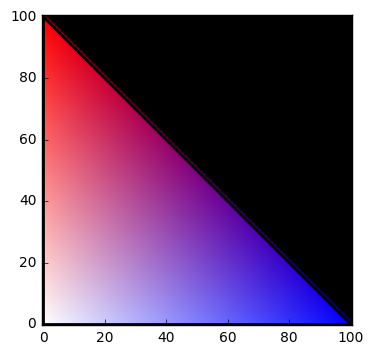

In [285]:
cmap = ColorMap([[0,0], [100,0], [0,100]], [(1,1,1), (0,0,1), (1,0,0)])
# cmap = ColorMap([[35,35], [65,35], [50,55.2]], [(1,1,1), (0,0,1), (1,0,0)], True)
# cmap = ColorMap([[35,35], [65,35], [65,65], [35,65]], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)], True)
# cmap = ColorMap([[50*x+50 for x in p] for p in poly_corners(3)], [(1,1,1), (0,0,1), (1,0,0)], True)
# cmap = ColorMap([[50*x+50 for x in p] for p in poly_corners(4)], [(0,0,0), (0,0,1), (1,1,1), (1,0,0)], True)
# cmap = ColorMap([[50*(x+1) for x in p] for p in poly_corners(5)], [(0,0,0), (0,0,1), (1,0,0), (0,1,0), (1,1,1)], True)
# cmap = ColorMap([[25*(x)+50 for x in p] for p in poly_corners(6)], [(0,0,1), (0,1,1), (0,1,0), (1,1,0), (1,0,0), (1,0,1)])
corners = cmap.coords
n = len(corners)
for i in range(n):
    x1,y1 = corners[i]
    x2,y2 = corners[(i+1)%n]
    plt.plot([x1,x2], [y1,y2], 'k', linewidth=2)

# print(cmap((-10,0)))
# print(cmap((10,0)))
# print(cmap((55,0)))
# print(cmap((90,0)))
# print(cmap((110,0)))
# print(cmap((30,50)))

cmap.verbose = False
# def filter(x,y):
#     return 35<=x<=65 and 35<=y<=65
# filter= lambda x,y: True
filter= lambda x,y: x+y<=100
plot_cmap(cmap, filter= filter, foo=1)

In [263]:
f = np.array([[ 0.11554175], [ 0.7314504 ], [ 0.15300785]]).T
np.concatenate((f,f))
a = [1,2,3]
print(a.extend(a))
print(a)
print(f[0,0:].tolist())
a[4:6]

None
[1, 2, 3, 1, 2, 3]
[0.11554175, 0.7314504, 0.15300785]


[2, 3]

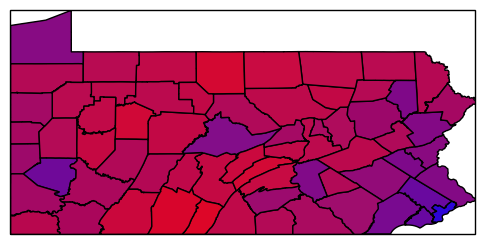

In [661]:
ax = plt.axes(projection=ccrs.PlateCarree())


# fig = plt.figure()#figsize=(8, 3))
# ax = fig.add_axes([0.05, 0.05, 0.85, 0.9], projection=ccrs.PlateCarree())
# ax2 = fig.add_axes([0.925, 0.15, 0.05, 0.7])

# ax = plt.axes(projection=ccrs.PlateCarree())
colormap = cm.get_cmap("Blues")
colormap.set_bad('orange')
colormap.set_over('g')
colormap.set_under('k')

# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[0,0], [100,0], [0,100]], [(0.5,0,0.5), (0,0,1), (1,0,0)])
# cmap = gen_cmap([[95,0], [100,0], [0,100], [0,95]], [(0,0,1), (0,0,1), (1,0,0), (1,0,0)])

# values = []
# for county,v in COUNTY_RESULTS.items():
#     meta = dict(COUNTY_RESULTS[k])
#     del meta["County"]
#     total = sum([int(f) for f in meta.values()])
#     vap = int(dict(VOTERS[k])["ALL"])
#     value = int(meta["TRUMP, DONALD J"])/sum([int(VOTERS[k]["REP"]), int(VOTERS[k]["OTH"]), int(VOTERS[k]["NOF"])])

for k,v in COUNTY_SHAPES.items():
    meta = COUNTY_RESULTS[k]
    total = sum(meta.values())
    clinton = meta[DC]
    trump = meta[RC]
    point = [clinton/total*100, trump/total*100]
    (x,y) = point
    if 95>x+y:
        print (k, x,y)
    color = cmap(point)
    cf = cfeature.ShapelyFeature([v], ccrs.PlateCarree())
    ax.add_feature(cf, facecolor=color)

ax.set_extent([-80.5198510000000027,-74.7215190000000007,39.7211469999999949,42.5160720000000012])
ax.set_aspect(1)

# cb1 = mpl.colorbar.ColorbarBase(ax2, cmap=colormap, norm=colors.Normalize(vmin=0, vmax=1), extend='max')

plt.show()

In [409]:
PAPER = 0
MIXED = 1
DRE = 2

VOTE_METHOD = {
"Adams": PAPER,
"Allegheny": DRE,
"Armstrong": DRE,
"Beaver": DRE,
"Bedford": MIXED,
"Berks": DRE,
"Blair": DRE,
"Bradford": DRE,
"Bucks": DRE,
"Butler": DRE,
"Cambria": DRE,
"Cameron": DRE,
"Carbon": DRE,
"Centre": PAPER,
"Chester": MIXED,
"Clarion": DRE,
"Clearfield": DRE,
"Clinton": DRE,
"Columbia": MIXED,
"Crawford": DRE,
"Cumberland": MIXED,
"Dauphin": DRE,
"Delaware": DRE,
"Elk": DRE,
"Erie": DRE,
"Fayette": MIXED,
"Forest": DRE,
"Franklin": PAPER,
"Fulton": PAPER,
"Greene": DRE,
"Huntingdon": PAPER,
"Indiana": PAPER,
"Jefferson": DRE,
"Juniata": PAPER,
"Lackawanna": PAPER,
"Lancaster": MIXED,
"Lawrence": DRE,
"Lebanon": DRE,
"Lehigh": DRE,
"Luzerne": MIXED,
"Lycoming": DRE,
"Mckean": DRE,
"Mercer": DRE,
"Mifflin": PAPER,
"Monroe": DRE,
"Montgomery": DRE,
"Montour": PAPER,
"Northampton": DRE,
"Northumberland": DRE,
"Perry": DRE,
"Philadelphia": DRE,
"Pike": DRE,
"Potter": DRE,
"Schuylkill": DRE,
"Snyder": PAPER,
"Somerset": DRE,
"Sullivan": DRE,
"Susquehanna": PAPER,
"Tioga": DRE,
"Union": DRE,
"Venango": DRE,
"Warren": DRE,
"Washington": DRE,
"Wayne": PAPER,
"Westmoreland": MIXED,
"Wyoming": DRE,
"York": DRE
}

-2.45373136105


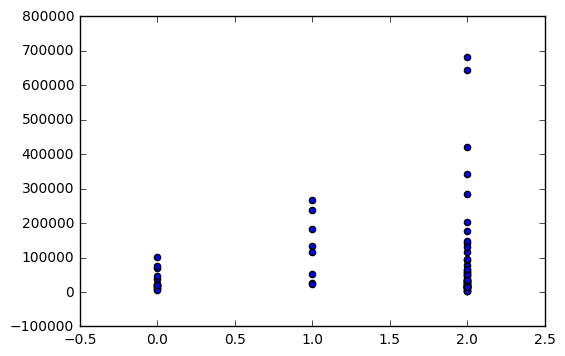

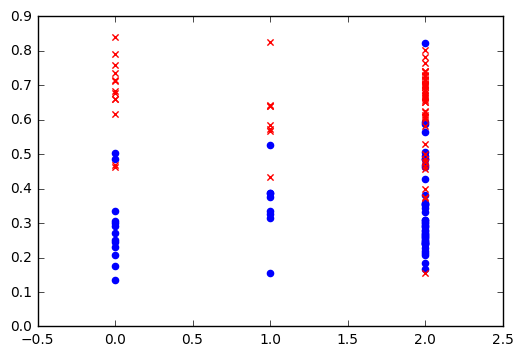

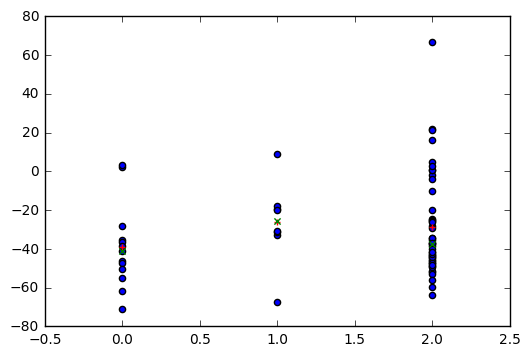

In [429]:
counties = VOTE_METHOD.keys()
x = [VOTE_METHOD[c] for c in counties]
totals = []
clinton = []
trump = []
delta = []
for c in counties:
    meta = dict(COUNTY_RESULTS[c])
    del meta["County"]
    total = sum([int(f) for f in meta.values()])
    totals.append(total)
    clinton.append(int(meta[DC])/total)
    trump.append(int(meta[RC])/total)
    delta.append((clinton[-1]-trump[-1])*100)
plt.figure()
plt.scatter(x,y)
plt.figure()
plt.scatter(x,clinton, color='blue')
plt.scatter(x,trump, color='red', marker='x')
plt.figure()
plt.scatter(x,delta)
d = np.array(delta)
k = np.array(x)

means_x = list(set(x))
means = [stat.mean(d[k==i]) for i in means_x]
medians = [stat.median(d[k==i]) for i in means_x]
plt.scatter(means_x, means, marker='+', color='red')
plt.scatter(means_x, medians, marker='x', color='green')
print(means[2]-means[1])
plt.show()

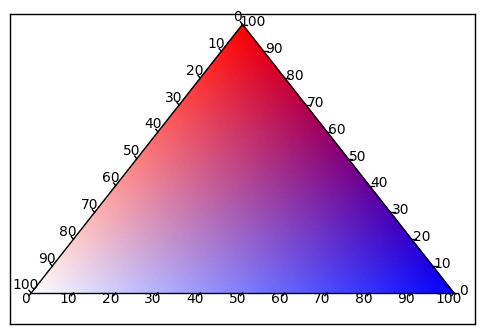

In [471]:
scale=100

data = dict()
for (i, j, k) in simplex_iterator(scale):
    data[(i, j, k)] = cmap((i,j))

figure, tax = ternary.figure(scale=scale)
tax.heatmap(data, style="triangular", colormap=False) # Allow colors as rgba tuples
tax.boundary()

tax.ticks(axis='lbr', multiple=10, linewidth=1)
# Remove default Matplotlib Axes
tax.clear_matplotlib_ticks()

plt.show()